# Phoenix BT-Settl Bolometric Corrections

Figuring out the best method of handling Phoenix bolometric correction files.

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import scipy.interpolate as scint

Change to directory containing bolometric correction files.

In [2]:
cd /Users/grefe950/Projects/starspot/starspot/color/tab/phx/

/Users/grefe950/Projects/starspot/starspot/color/tab/phx


Load a bolometric correction table, say for the Cousins AB photometric system.

In [3]:
bc_table = np.genfromtxt('colmag.BT-Settl.server.JOHNSON.AB.bolcor', comments='!')

Now, the structure of the file is quite irregular. The grid is not rectangular, which is not an immediate problem. The table is strucutred such that column 0 contains Teff in increasing order, followed by logg in column 1 in increasing order. However, metallicities in column 2 appear to be in decreasing order, which may be a problem for simple interpolation routines. Alpha abundances follow and are in increasing order, but since this is a "standard" grid, whereby alpha enrichment is a function of metallicity, we can ignore it for the moment.

Let's take a first swing at the problem by using the LinearND Interpolator from SciPy.

In [4]:
test_surface = scint.LinearNDInterpolator(bc_table[:, :3], bc_table[:, 4:])

The surface compiled, but that is not a guarantee that the interpolation will work successfully. Some tests are required to confirm this is the case. Let's try a few Teffs at logg = 5 with solar metallicity.

In [5]:
test_surface(np.array([1500., 5.0, 0.0]))

array([[-20.192, -15.501, -17.069, -10.796,  -7.214,  -5.066,  -4.49 ,
         -3.41 ,  -3.274,  -2.241]])

This agrees with data in the bolometric correciton table.
```
 Teff      logg   [Fe/H]  [a/Fe]         B           V           R           I
1500.00    5.00    0.00    0.00       -15.557     -16.084     -11.560      -9.291
```
Now, let's raise the temperature.

In [6]:
test_surface(np.array([3000., 5.0, 0.0]))

array([[-8.288, -6.543, -5.633, -4.19 , -2.879, -2.032, -1.525, -1.225,
        -1.055, -0.895]])

Again, we have a good match to tabulated values,
```
 Teff      logg   [Fe/H]  [a/Fe]         B           V           R           I
3000.00    5.00    0.00    0.00        -6.603      -5.641      -4.566      -3.273
```
However, since we are using a tabulated metallicity, the interpolation may proceed without too much trouble. If we select a metallicity between grid points, how do we fare?

In [7]:
test_surface(np.array([3000., 5.0, 0.1]))

array([[-8.17633333, -6.53033333, -5.65533333, -4.21666667, -2.88966667,
        -2.02466667, -1.52166667, -1.22366667, -1.04933333, -0.89166667]])

This appears consistent. What about progressing to lower metallicity values?

In [8]:
test_surface(np.array([3000., 5.0, -0.2]))

array([[-8.2728, -6.513 , -5.5734, -4.1376, -2.8446, -2.0288, -1.5458,
        -1.2418, -1.0618, -0.9086]])

For reference, at [Fe/H] = $-0.5$ dex, we have
```
 Teff      logg   [Fe/H]  [a/Fe]         B           V           R           I
3000.00    5.00   -0.50    0.20        -6.533      -5.496      -4.424      -3.154
```
The interpolation routine has seemingly handled the non-monotonic nature of the metallicity column, as all interpolate values lie between values at the two respective nodes.

---

Now let's import an isochrone and calcuate colors for stellar models for comparison against MARCS bolometric corrections.

In [9]:
iso = np.genfromtxt('/Users/grefe950/evolve/dmestar/iso/dmestar_00120.0myr_z+0.00_a+0.00_marcs.iso')

Make sure there are magnitudes and colors associated with this isochrone.

In [10]:
iso.shape

(59, 11)

A standard isochrone would only have 6 columns, so 11 indicates this isochrone does have photometric magnitudes computed, likely BV(Ic) (JK)2MASS.

In [11]:
test_bcs = test_surface(10**iso[:,1], iso[:, 2], 0.0)

In [12]:
test_bcs.shape

(59, 10)

For each Teff and logg combination we now have BCs for BV(RI)c from BT-Settl models. Now we need to convert the bolometric corrections to absolute magnitudes.

In [13]:
bol_mags = 4.74 - 2.5*iso[:, 3]
for i in range(test_bcs.shape[1]):
    bcs = -1.0*np.log10(10**iso[:, 1]/5777.) + test_bcs[:, i] - 5.0*iso[:, 4]
    if i == 0:
        test_mags = bol_mags - bcs
    else:
        test_mags = np.column_stack((test_mags, bol_mags - bcs))
iso[50, 0:4], iso[50, 6:], test_mags[50]

(array([ 1.25      ,  3.81037521,  4.40329409,  0.32647139]),
 array([ 4.38597631,  3.93303084,  3.40876961,  3.06119251,  2.81017828]),
 array([ 3.40771886,  3.58363331,  3.74523445,  3.84910017,  3.93369928,
         4.03720307,  4.15110173,  4.16752955,  4.15451344,  4.1877559 ]))

Let's try something different: using the color tables provided by the Phoenix group, from which the bolometric corrections are calculated.

In [14]:
col_table = np.genfromtxt('colmag.BT-Settl.server.COUSINS.AB', comments='!')

Create an interpolation surface from the magnitude table.

In [15]:
col_surface = scint.LinearNDInterpolator(col_table[:, :3], col_table[:, 4:8])

Compute magnitudes for a Dartmouth isochrone.

In [16]:
phx_mags = col_surface(10.0**iso[:, 1], iso[:, 2], 0.0)

Convert surface magnitudes to absolute magnitudes using the distance modulus and the radius of the star.

In [17]:
for i in range(phx_mags.shape[1]):
    phx_mags[:, i] = phx_mags[:, i] - 5.0*np.log10(10**iso[:, 4]*6.956e10/3.086e18) + 5.0

Now compare against MARCS values.

In [18]:
iso[40, :5], iso[40, 6:], phx_mags[40]

(array([ 0.89999998,  3.72441459,  4.59612942, -0.3528868 , -0.1020125 ]),
 array([ 6.58101368,  5.78752756,  4.95509005,  4.36883259,  3.88979053]),
 array([ 6.47722803,  5.79107822,  5.49384859,  5.35485952]))

Load an isochrone from the Lyon-Phoenix series.

In [19]:
phx_iso = np.genfromtxt('/Users/grefe950/Notebook/Projects/ngc2516_spots/data/phx_isochrone_120myr.txt')

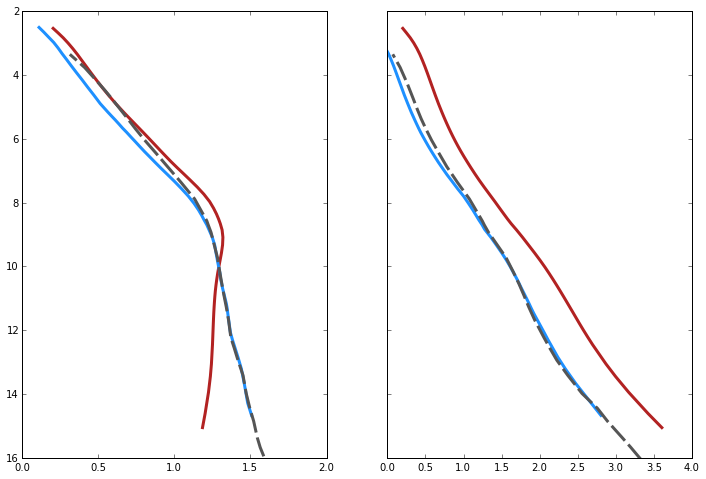

In [20]:
fig, ax = plt.subplots(1, 2, figsize=(12., 8.), sharey=True)

ax[0].set_xlim(0.0, 2.0)
ax[1].set_xlim(0.0, 4.0)
ax[0].set_ylim(16, 2)

ax[0].plot(iso[:, 6] - iso[:, 7], iso[:, 7], lw=3, c="#b22222")
ax[0].plot(phx_mags[:, 0] - phx_mags[:, 1], phx_mags[:, 1], lw=3, c="#1e90ff")
ax[0].plot(phx_iso[:, 7] - phx_iso[:, 8], phx_iso[:, 8], dashes=(20., 5.), lw=3, c="#555555")

ax[1].plot(iso[:, 7] - iso[:, 8], iso[:, 7], lw=3, c="#b22222")
ax[1].plot(phx_mags[:, 1] - phx_mags[:, 3], phx_mags[:, 1], lw=3, c="#1e90ff")
ax[1].plot(phx_iso[:, 8] - phx_iso[:, 10], phx_iso[:, 8], dashes=(20., 5.), lw=3, c="#555555")

Export a new isochrone with colors from AGSS09 (PHX)

In [21]:
new_isochrone = np.column_stack((iso[:, :6], phx_mags))
np.savetxt('/Users/grefe950/Notebook/Projects/pleiades_colors/data/dmestar_00120.0myr_z+0.00_a+0.00_mixed.iso', 
            new_isochrone, fmt='%16.8f')

---

### Separate Test Case

These are clearly not correct and are between 1 and 2 magnitudes off from expected values. Need to reproduce the Phoenix group's results, first.

In [22]:
tmp = -10.*np.log10(3681./5777.) + test_surface(3681., 4.78, 0.0) #+ 5.0*np.log10(0.477)
tmp 

array([-3.3501845, -2.0513845, -1.3280945, -0.5624445,  0.1168055,
        0.6088855,  1.0849855,  1.2521055,  1.3291755,  1.4216855])

In [23]:
4.74 - 2.5*(-1.44) - tmp

array([ 11.6901845,  10.3913845,   9.6680945,   8.9024445,   8.2231945,
         7.7311145,   7.2550145,   7.0878945,   7.0108245,   6.9183145])